In [1]:
import healpy as h
import sys  ; sys.path.append("../../codes/")
from modules import euler as euler
from modules import rs_rad_ker as rk
from modules import aliasing_correction as ac
from scipy.interpolate import interp1d

%pylab notebook
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
nside=256 ; npix=h.nside2npix(nside)
sampling=4500
lmax=2*nside

pxsize=np.sqrt(4.*pi/h.nside2npix(nside))
beta0=min(180,180.*32/(lmax))*np.pi/180. ; print beta0*180/pi

theta,pl2=rk.get_plm0(lmax,sampling,theta_max=min(pi,3.*beta0))
theta_cutoff=beta0

figpath="./figures/"
!mkdir $figpath

11.25
mkdir: ./figures/: File exists


In [3]:
cltemp=h.read_cl("../../data/cl_rem3.fits")
cltemp=h.read_cl("../../data/planck_wp_highL_lensing_param.fits")
clr=[cltemp[0],cltemp[1],cltemp[2]*0.1,cltemp[3]*0]

def get_alm(cl,lmax,seed=0):
    random.seed(seed)
    almsize=h.Alm.getsize(lmax,lmax)
    ar=random.normal(size=almsize)
    ai=random.normal(size=almsize)
    alm=zeros(almsize,complex)
    for i in range(almsize):
        l,m=h.Alm.getlm(lmax,i)
        if m==0:
            alm[i]=complex(ar[i],0.)*sqrt(cl[l])
        else:
            alm[i]=complex(ar[i],ai[i])*sqrt(0.5*cl[l])
    return alm

almt=get_alm(clr[0],lmax,1) ; alme=get_alm(clr[1],lmax,2) ; almb=get_alm(clr[2],lmax,3)
true_alm=[almt,alme,almb] ; cltrue=h.alm2cl(true_alm)

tqu=h.alm2map(true_alm,nside,pol=True) ; alm=h.map2alm(tqu,lmax=lmax)
cl=h.alm2cl(alm) ; teb=h.alm2map(alm,nside,pol=False)

true_teb=h.alm2map(true_alm,nside,pol=False)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [4]:
apow=rk.fn_apodization(theta,theta_cutoff=theta_cutoff,apow_frac=1.)
rad_ker=rk.calc_qu2eb_rad_ker(lmax,theta,pl2)# Default
rad_ker_i,rad_ker_d=rk.calc_qu2queb_rad_ker(lmax,theta,pl2)# Default
#rad_ker=rk.mod_rad_ker(theta,shift=0.05,amp=1,width=0.01,slope=2,expslope=2)# Modified

In [5]:
figure()
plot(theta,rad_ker)
plot(theta,rad_ker*apow,"--")
plot(theta,rad_ker_i,"--")
plot(theta,apow*max(rad_ker))
axvline(pxsize)
xlim(0,1.5*theta_cutoff)
rad_ker=rad_ker*apow

<IPython.core.display.Javascript object>

In [8]:
ctqu=ac.correct_aliasing(tqu[1],tqu[2],theta_cutoff,theta,rad_ker_i,iter=0,mask=mask)

In [9]:
fn_rad_ker=interp1d(np.cos(theta)[::-1],rad_ker[::-1],assume_sorted=True,kind="cubic",bounds_error=False,fill_value=0.0)
domega=4.*np.pi/float(npix)

<IPython.core.display.Javascript object>


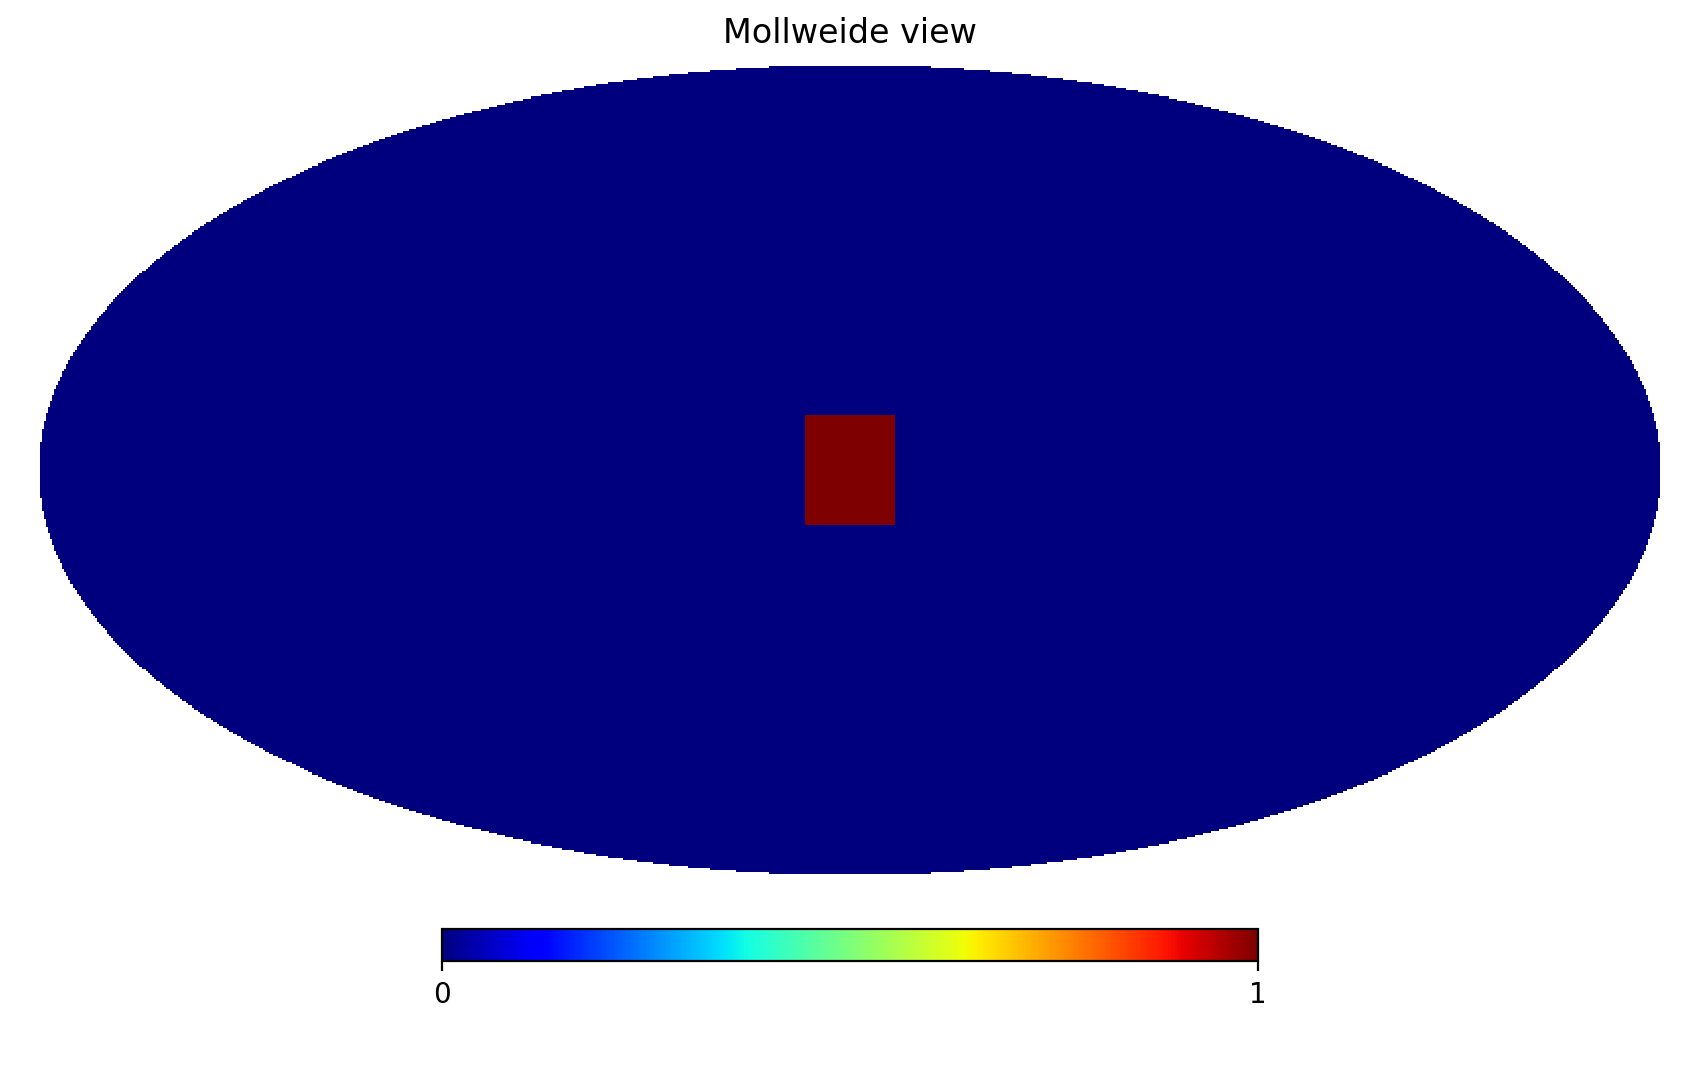

In [7]:
lat=90
tmask=zeros(npix,float)
pmask=zeros(npix,float)
pindex=arange(npix)
theta0,phi0=h.pix2ang(nside,pindex)
theta0=theta0*180/pi ; phi0=phi0*180/pi
wband=10 ; phiband=10
tmask[theta0<lat-wband]=1 ; tmask[theta0>lat+wband]=1.
pmask[phi0<phiband]=1. ; pmask[phi0>360-phiband]=1.
mask=pmask*(1-tmask) ; fsky=sum(mask)/size(mask)

h.mollview(mask)

In [10]:
pix_list=nonzero(mask)[0]
pix_list.size

print pix_list

random.shuffle(pix_list)
print pix_list

[325120 325121 325122 ..., 461309 461310 461311]
[428526 384524 395773 ..., 368101 329204 423436]


In [23]:
h.gnomview?